In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SpectralAnomalyScoreExt,
                                 AlertExpressionWithFilterExt)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1986: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [2]:
# setting to make life easier
Temperature='Temperature'
kmeans='TemperatureKmeansScore'
fft='TemperatureFFTScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

#kmeans_break=1.3
#spectral_break = 2.8
#fft_break = 100
#sal_break = 100
#gen_break = 30000
kmeans_break=100
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000


In [3]:

# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./samples/AzureAnomalysample.csv', index_col=False, parse_dates=['timestamp'])

df_i['id']='MyRoom'
df_i['Temperature']=df_i['value'] + 20
df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['id','timestamp']).dropna()

df_i.head(2)

Temperature
id     timestamp                       
MyRoom 2017-10-09 20:32:00         23.0
       2017-10-09 20:33:00         23.0

In [4]:
# Now run the anomaly functions as if they were executed in a pipeline

Temperature = 'temp'
aexgi = bif.AnomalyGeneratorExtremeValue('Temperature',5, 0.4, 'temp')
et = aexgi._build_entity_type(columns = [Column('Temperature',Float())])
aexgi._entity_type = et
df_i = aexgi.execute(df=df_i)

spsi = SpectralAnomalyScoreExt(Temperature, 12, spectral, 'inv_zscore')
et = spsi._build_entity_type(columns = [Column(Temperature,Float())])
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

sali = SaliencybasedGeneralizedAnomalyScore(Temperature, 12, sal)
et = sali._build_entity_type(columns = [Column(Temperature,Float())])
sali._entity_type = et
df_i = sali.execute(df=df_i)

ffti = FFTbasedGeneralizedAnomalyScore(Temperature, 12, fft)
et = ffti._build_entity_type(columns = [Column(Temperature,Float())])
ffti._entity_type = et
df_i = ffti.execute(df=df_i)

kmi = KMeansAnomalyScore(Temperature, 2, kmeans)
et = kmi._build_entity_type(columns = [Column(Temperature,Float())])
kmi._entity_type = et
df_i = kmi.execute(df=df_i)

df_i.head(4)

2020-03-19T17:56:33.773 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-03-19T17:56:33.774 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-19T17:56:33.775 ERROR iotfunctions.bif.execute Checking for derived metric table temp failed with 'NoneType' object has no attribute 'query'.
2020-03-19T17:56:33.775 ERROR iotfunctions.bif.execute Counts by entity id not yet initialized - error: 'NoneType' object has no attribute 'model_store'
id
5 
 (4000,) 
 (5, 800) 
 (800,) 
 (800,)
(4000,)     (5, 800)
2020-03-19T17:56:33.783 ERROR iotfunctions.bif.execute Counts by entity id cannot be stored - error: 'NoneType' object has no attribute 'model_store'
2020-03-19T17:56:33.783 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-03-19T17:56:33.784 WARNING iotf

Temperature  temp  TemperatureSpectralScore  \
id     timestamp                                                          
MyRoom 2017-10-09 20:32:00         23.0  -0.0                150.887474   
       2017-10-09 20:33:00         23.0  23.0                122.720879   
       2017-10-09 20:34:00         23.0  23.0                 94.554283   
       2017-10-09 20:35:00         23.0  23.0                 66.387688   

                            inv_zscore  SaliencyAnomalyScore  \
id     timestamp                                               
MyRoom 2017-10-09 20:32:00    5.819601              5.552267   
       2017-10-09 20:33:00    4.784793              6.188458   
       2017-10-09 20:34:00    3.749984              6.824650   
       2017-10-09 20:35:00    2.715175              7.460841   

                            TemperatureFFTScore  TemperatureKmeansScore  
id     timestamp                                                         
MyRoom 2017-10-09 20:32:00         1.381168e+06                0.175893  
       2017-10-09 20:33:00         1.183866e+06                0.116803  
       2017-10-09 20:34:00         9.865640e+05                0.057714  
       2017-10-09 20:35:00         7.892620e+05                0.057699

In [5]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['MyRoom']]
df_inputm2.reset_index(level=[0], inplace=True)

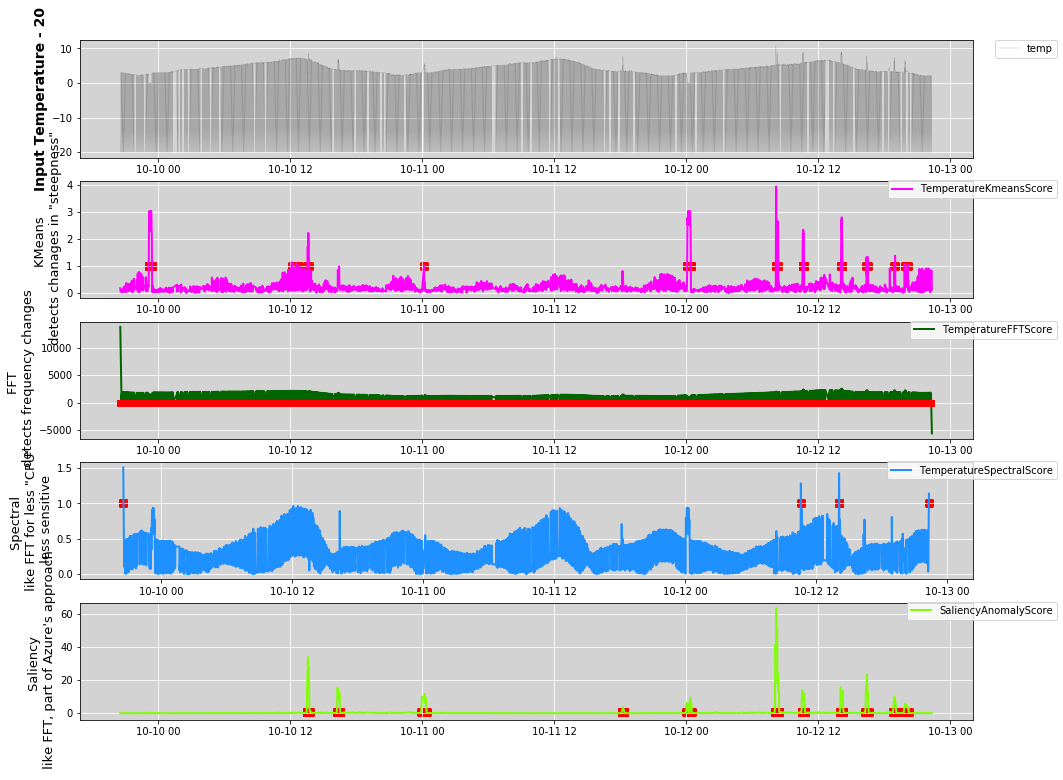

In [6]:
# Scale and plot
kmeans_break = 1.0
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break

df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break
df_inputm2[spectralA] = df_inputm2[spectral]
df_inputm2[spectralA].values[df_inputm2[spectralA] < spectral_break] = np.nan
df_inputm2[spectralA].values[df_inputm2[spectralA] > spectral_break] = spectral_break
df_inputm2[salA] = df_inputm2[sal]
df_inputm2[salA].values[df_inputm2[salA] < sal_break] = np.nan
df_inputm2[salA].values[df_inputm2[salA] > sal_break] = sal_break

plots = 5
anolw = 3

fig, ax_ = plt.subplots(plots, 1, figsize=(16,plots * 2.5))
ax = np.atleast_1d(ax_).ravel()
cnt = 0
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=0.1,color='black',label=Temperature)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = 1
#ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].scatter(df_inputm2.index, df_inputm2[kmeansA], linewidth=anolw, marker='s', color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt = 2
#ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=anolw, marker='s', color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)
cnt = 3
#ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].scatter(df_inputm2.index, df_inputm2[spectralA]/spectral_break, linewidth=anolw, marker='s', color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n like FFT for less "CPU"\n less sensitive', fontsize=13)
cnt = 4
#ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].scatter(df_inputm2.index, df_inputm2[salA]/sal_break, linewidth=anolw, marker='s', color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n like FFT, part of Azure\'s approach', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

Continuing with FFT

In [9]:
expr = '${' + fft + '} > 1'
aexwfei = AlertExpressionWithFilterExt(expr, None, None, False, 'fftalert')
et = aexwfei._build_entity_type(columns = [Column(fft,Float())])
aexwfei._entity_type = et
df_i = aexwfei.execute(df=df_i)

expr = '${' + fft + '} > 1'
aexwfei2 = AlertExpressionWithFilterExt(expr, None, None, True, 'fftalertp')
et = aexwfei2._build_entity_type(columns = [Column(fft,Float())])
aexwfei2._entity_type = et
df_i = aexwfei2.execute(df=df_i)

2020-03-19T17:57:46.197 INFO mmfunctions.anomaly.__init__ AlertExpressionWithFilter  dim: None  exp: ${TemperatureFFTScore} > 1  alert: fftalert
2020-03-19T17:57:46.198 INFO mmfunctions.anomaly.__init__ AlertExpressionWithFilterExt  dim: None  exp: ${TemperatureFFTScore} > 1  alert: fftalert  pulsed: False
2020-03-19T17:57:46.200 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-03-19T17:57:46.201 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-19T17:57:46.205 INFO mmfunctions.anomaly.execute AlertExpressionWithFilter  exp: ${TemperatureFFTScore} > 1  input: Index(['Temperature', 'temp', 'TemperatureSpectralScore', 'inv_zscore',
       'SaliencyAnomalyScore', 'TemperatureFFTScore', 'TemperatureKmeansScore',
       'fftalertp'],
      dtype='object')
2020-03-19T17:57:46.206 INFO mmfunctions.anomaly.execute 

In [10]:
data = df_i['fftalert'].values.astype(float)
datap = df_i['fftalertp'].values.astype(float)

Text(0.5, 1.0, 'Single alert is enough - value is sequence length')

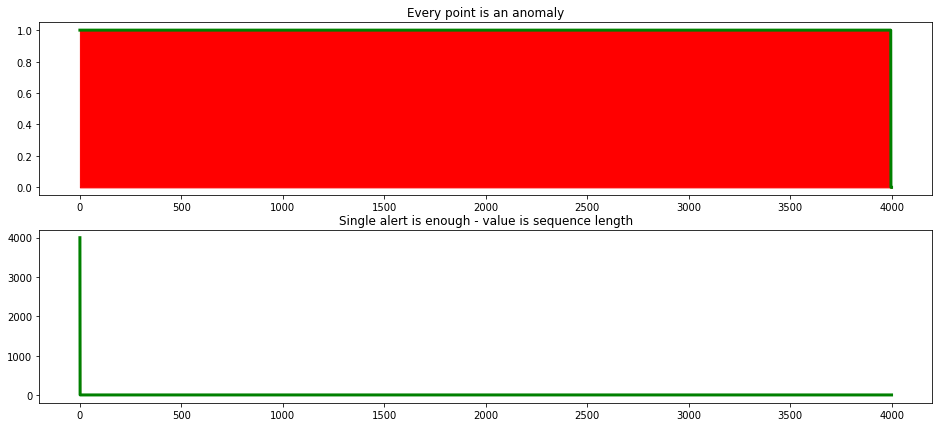

In [12]:
fig, ax_ = plt.subplots(2, 1, figsize=(16,7))
ax = np.atleast_1d(ax_).ravel()
cnt = 0
ax[cnt].plot(range(0,4000), data, linewidth=3,color='green', label=sal)
ax[cnt].fill_between(range(0,4000),np.zeros(4000), data, color='red')
ax[cnt].set_title('Every point is an anomaly')
cnt = 1
ax[cnt].plot(range(0,4000), datap, linewidth=3,color='green', label=sal)
ax[cnt].fill_between(range(0,4000),np.zeros(4000), datap, color='red')
ax[cnt].set_title('Single alert is enough - value is sequence length')